# Imports

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

## Checking GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Creating the Datasets

Define paramters for the data loaders

In [3]:
batch_size = 8
img_height = 48
img_width = 48
color_mode = 'grayscale' # One of "grayscale", "rgb", "rgba".
validation_split = 0.2

dataset = "CK+" # One of "CK+" , "FER_2013"

train_data = "data/"+ dataset + "/train/"
test_data = "data/"+ dataset + "/test/"

print(train_data)
print(test_data)

data/CK+/train/
data/CK+/test/


Load the data into the datasets

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    label_mode="categorical",
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    shuffle=False,
    color_mode = color_mode,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 720 files belonging to 7 classes.
Using 576 files for training.
Found 720 files belonging to 7 classes.
Using 144 files for validation.
Found 182 files belonging to 7 classes.


View the classes in the dataset

In [5]:
class_names = test_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Configuring the Datset
Enable buffered prefetching so you can yield data from disk without having I/O become blocking

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

In [7]:
from tensorflow.keras.layers import Input, Conv2D , MaxPool2D, Flatten, Dense , Dropout
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers
from importlib import reload 
from tensorflow.keras.applications.resnet50 import ResNet50


import cnn_models
import importlib
importlib.reload(cnn_models)
from cnn_models import *

model_name="ResNet50_V1_Attention"

# model = test_attention(grayscale=True)

model = model_ResNet50_V1(grayscale=True , attention="CBAM")

# input_tensor = Input(shape=(img_height, img_width, 1))

# model = ResNet50(include_top=False ,weights=None, input_tensor=input_tensor)

## Compile the model

In [8]:
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## View Model Summary

In [9]:
model.summary()

Model: "ResNet50_V1ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 Conv1_Pad (ZeroPadding2D)      (None, 54, 54, 1)    0           ['input_1[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 24, 24, 64)   3200        ['Conv1_Pad[1][0]']              
                                                                                                  
 Conv1_BN (BatchNormalization)  (None, 24, 24, 64)   96          ['Conv1[1][0]']                  
                                                                                

 Conv2_Block3_1_Relu (Activatio  (None, 12, 12, 64)  0           ['Conv2_Block3_1_BN[1][0]']      
 n)                                                                                               
                                                                                                  
 Conv2_Block3_2_Conv (Conv2D)   (None, 12, 12, 64)   36928       ['Conv2_Block3_1_Relu[1][0]']    
                                                                                                  
 Conv2_Block3_2_BN (BatchNormal  (None, 12, 12, 64)  48          ['Conv2_Block3_2_Conv[1][0]']    
 ization)                                                                                         
                                                                                                  
 Conv2_Block3_2_Relu (Activatio  (None, 12, 12, 64)  0           ['Conv2_Block3_2_BN[1][0]']      
 n)                                                                                               
          

                                                                                                  
 Conv3_Block3_1_BN (BatchNormal  (None, 6, 6, 128)   24          ['Conv3_Block3_1_Conv[1][0]']    
 ization)                                                                                         
                                                                                                  
 Conv3_Block3_1_Relu (Activatio  (None, 6, 6, 128)   0           ['Conv3_Block3_1_BN[1][0]']      
 n)                                                                                               
                                                                                                  
 Conv3_Block3_2_Conv (Conv2D)   (None, 6, 6, 128)    147584      ['Conv3_Block3_1_Relu[1][0]']    
                                                                                                  
 Conv3_Block3_2_BN (BatchNormal  (None, 6, 6, 128)   24          ['Conv3_Block3_2_Conv[1][0]']    
 ization) 

 Conv4_Block1_Output (Activatio  (None, 3, 3, 1024)  0           ['Conv4_Block1_Add[1][0]']       
 n)                                                                                               
                                                                                                  
 Conv4_Block2_1_Conv (Conv2D)   (None, 3, 3, 256)    262400      ['Conv4_Block1_Output[1][0]']    
                                                                                                  
 Conv4_Block2_1_BN (BatchNormal  (None, 3, 3, 256)   12          ['Conv4_Block2_1_Conv[1][0]']    
 ization)                                                                                         
                                                                                                  
 Conv4_Block2_1_Relu (Activatio  (None, 3, 3, 256)   0           ['Conv4_Block2_1_BN[1][0]']      
 n)                                                                                               
          

                                                                                                  
 Conv4_Block5_1_Conv (Conv2D)   (None, 3, 3, 256)    262400      ['Conv4_Block4_Output[1][0]']    
                                                                                                  
 Conv4_Block5_1_BN (BatchNormal  (None, 3, 3, 256)   12          ['Conv4_Block5_1_Conv[1][0]']    
 ization)                                                                                         
                                                                                                  
 Conv4_Block5_1_Relu (Activatio  (None, 3, 3, 256)   0           ['Conv4_Block5_1_BN[1][0]']      
 n)                                                                                               
                                                                                                  
 Conv4_Block5_2_Conv (Conv2D)   (None, 3, 3, 256)    590080      ['Conv4_Block5_1_Relu[1][0]']    
          

                                                                 , 'Conv5_Block1_3_BN[1][0]']     
                                                                                                  
 Conv5_Block1_Output (Activatio  (None, 2, 2, 2048)  0           ['Conv5_Block1_Add[1][0]']       
 n)                                                                                               
                                                                                                  
 Conv5_Block2_1_Conv (Conv2D)   (None, 2, 2, 512)    1049088     ['Conv5_Block1_Output[1][0]']    
                                                                                                  
 Conv5_Block2_1_BN (BatchNormal  (None, 2, 2, 512)   8           ['Conv5_Block2_1_Conv[1][0]']    
 ization)                                                                                         
                                                                                                  
 Conv5_Blo

Plot the the CNN Model

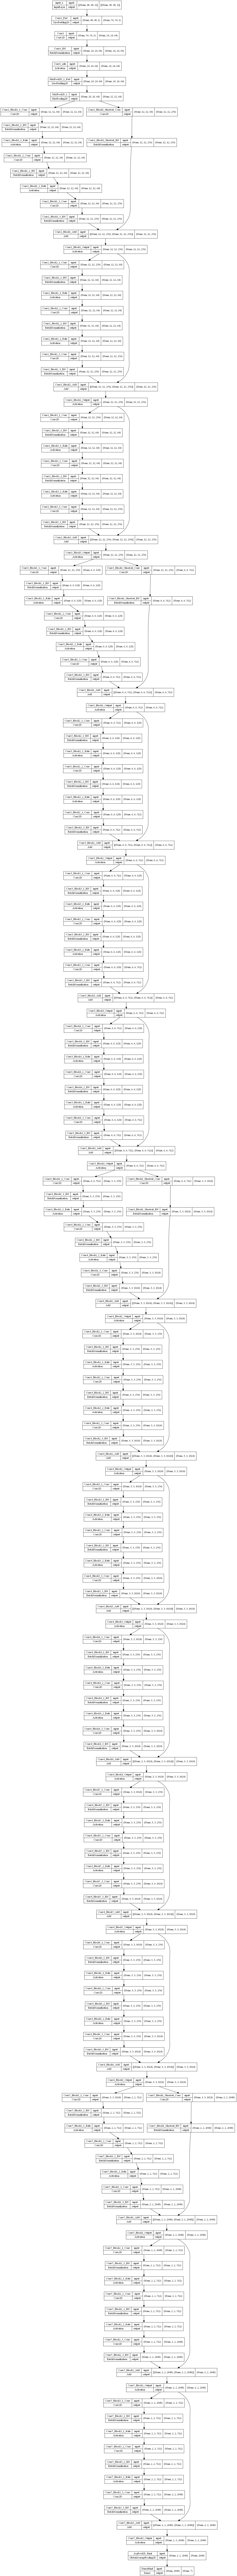

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image 


plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
# Image('model.png', width = 400)

## Train the Model

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

name = [model_name, dataset , 'weights']
name = '_'.join(name) + ".hdf5"

checkpoint_file_path = "models/" + name


checkpoint = ModelCheckpoint(filepath=checkpoint_file_path,
                            monitor="val_loss",
                            verbose = 1,
                            save_best_only = True,
                            save_weights_only = False,
                            mode= "auto",
                            save_freq= "epoch",
                            options=None)


early_stop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0, # Minimum change in the monitored quantity to qualify as an improvemen
                          patience=5, # Number of epochs with no improvement after which training will be stopped
                          verbose=1,
                          mode='auto')

In [ ]:
epochs=30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = [checkpoint] 
)

Epoch 1/30
72/72 [==============================] - ETA: 0s - loss: 1.9250 - accuracy: 0.6094
Epoch 1: val_loss improved from inf to 1.63580, saving model to models\ResNet50_V1_Attention_CK+_weights.hdf5
72/72 [==============================] - 14s 112ms/step - loss: 1.9250 - accuracy: 0.6094 - val_loss: 1.6358 - val_accuracy: 0.6528
Epoch 2/30
72/72 [==============================] - ETA: 0s - loss: 1.6031 - accuracy: 0.6372
Epoch 2: val_loss improved from 1.63580 to 1.42564, saving model to models\ResNet50_V1_Attention_CK+_weights.hdf5
72/72 [==============================] - 7s 102ms/step - loss: 1.6031 - accuracy: 0.6372 - val_loss: 1.4256 - val_accuracy: 0.6528
Epoch 3/30
72/72 [==============================] - ETA: 0s - loss: 1.4430 - accuracy: 0.6458
Epoch 3: val_loss did not improve from 1.42564
72/72 [==============================] - 4s 56ms/step - loss: 1.4430 - accuracy: 0.6458 - val_loss: 1.4673 - val_accuracy: 0.6528
Epoch 4/30
71/72 [============================>.] - ET

72/72 [==============================] - 4s 55ms/step - loss: 0.0311 - accuracy: 0.9861 - val_loss: 0.3878 - val_accuracy: 0.9028
Epoch 29/30
72/72 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9913
Epoch 29: val_loss improved from 0.35165 to 0.32008, saving model to models\ResNet50_V1_Attention_CK+_weights.hdf5


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(loss, label='train')
plt.plot(val_loss, label='test')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(acc, label='train')
plt.plot(val_acc, label='test')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Evaluate")
model.load_weights(checkpoint_file_path) #Load the best weights from the file
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

## Confusion Matrix and Classification

## Evaluate the Model

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report

# defines which dataset we want to show the confusion matrix and classification report 
dataset = test_ds

predition_list = []
label_list = []

# Get predictions from the model
predictions = model.predict(dataset)
for prediction in predictions:
    predition_list.append(np.argmax(prediction))
    
# Get lables from the test set
labels = np.concatenate([y for x, y in dataset], axis=0)
for label in labels:
    label_list.append(np.argmax(label))
    
# create a confusion matrix
confusion_mtx = tf.math.confusion_matrix(label_list, predition_list , num_classes=7)

# Function that displays the confusion matrix
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()


print(classification_report(label_list, predition_list, target_names=class_names))
show_confusion_matrix(confusion_mtx, class_names)
